# Table of Contents
 <p><div class="lev1"><a href="#Introduction"><span class="toc-item-num">1 - </span>Introduction</a></div><div class="lev1"><a href="#Folder-initialization-&amp;-imports"><span class="toc-item-num">2 - </span>Folder initialization &amp; imports</a></div><div class="lev1"><a href="#Mapping-to-experimental-structures"><span class="toc-item-num">3 - </span>Mapping to experimental structures</a></div><div class="lev2"><a href="#Loading-the-GEM"><span class="toc-item-num">3.1 - </span>Loading the GEM</a></div><div class="lev2"><a href="#Dataframe-creation"><span class="toc-item-num">3.2 - </span>Dataframe creation</a></div><div class="lev3"><a href="#Mapping-gene-IDs-to-UniProt-IDs"><span class="toc-item-num">3.2.1 - </span>Mapping gene IDs to UniProt IDs</a></div><div class="lev4"><a href="#Manually-mapping-ones-that-didn't-map"><span class="toc-item-num">3.2.1.1 - </span>Manually mapping ones that didn't map</a></div><div class="lev3"><a href="#Mapping-UniProt-IDs-to-PDB-IDs"><span class="toc-item-num">3.2.2 - </span>Mapping UniProt IDs to PDB IDs</a></div><div class="lev4"><a href="#Alternate-mapping:-BLASTing-the-PDB"><span class="toc-item-num">3.2.2.1 - </span>Alternate mapping: BLASTing the PDB</a></div><div class="lev3"><a href="#Creating-and-saving-the-mapping-Dataframe"><span class="toc-item-num">3.2.3 - </span>Creating and saving the mapping Dataframe</a></div><div class="lev3"><a href="#Obtaining-sequence-metadata"><span class="toc-item-num">3.2.4 - </span>Obtaining sequence metadata</a></div><div class="lev3"><a href="#Obtaining-structure-metadata"><span class="toc-item-num">3.2.5 - </span>Obtaining structure metadata</a></div><div class="lev3"><a href="#Final-integrated-DataFrame"><span class="toc-item-num">3.2.6 - </span>Final integrated DataFrame</a></div><div class="lev1"><a href="#Mapping-to-homology-models"><span class="toc-item-num">4 - </span>Mapping to homology models</a></div><div class="lev2"><a href="#Loading-existing-gene--&gt;-homology-model-dataframe"><span class="toc-item-num">4.1 - </span>Loading existing gene -&gt; homology model dataframe</a></div><div class="lev2"><a href="#Merging-with-the-created-GEM-PRO"><span class="toc-item-num">4.2 - </span>Merging with the created GEM-PRO</a></div><div class="lev1"><a href="#Ranking-experimental-structures"><span class="toc-item-num">5 - </span>Ranking experimental structures</a></div><div class="lev2"><a href="#Scoring-sequence-identity"><span class="toc-item-num">5.1 - </span>Scoring sequence identity</a></div><div class="lev3"><a href="#Writing-FASTA-files-for-the-original-sequence"><span class="toc-item-num">5.1.1 - </span>Writing FASTA files for the original sequence</a></div><div class="lev3"><a href="#Writing-FASTA-files-for-the-structures"><span class="toc-item-num">5.1.2 - </span>Writing FASTA files for the structures</a></div><div class="lev3"><a href="#Aligning-the-structures-to-the-sequence"><span class="toc-item-num">5.1.3 - </span>Aligning the structures to the sequence</a></div><div class="lev3"><a href="#Scoring"><span class="toc-item-num">5.1.4 - </span>Scoring</a></div><div class="lev2"><a href="#Scoring-resolution"><span class="toc-item-num">5.2 - </span>Scoring resolution</a></div><div class="lev2"><a href="#Merging-scores-&amp;-ranking"><span class="toc-item-num">5.3 - </span>Merging scores &amp; ranking</a></div><div class="lev1"><a href="#Saving-the-final-GEM-PRO-dataframe"><span class="toc-item-num">6 - </span>Saving the final GEM-PRO dataframe</a></div>

# Introduction

<span style="background-color:#66FF99">**This IPython notebook will guide you through the creation of a GEM-PRO, for the *E. coli* model iJO1366.**</span>

There are three main stages to this workflow.

1. Mapping gene IDs to experimentally solved protein structures, available in the Protein Data Bank (PDB)
2. Creating new or mapping to existing homology models for genes that do not have an experimentally solved structure.
3. Ranking available experimentally solved structures.

Following notebooks will outline how we can use this GEM-PRO for strain specific comparisons through 55 *E. coli* strains.

# Folder initialization & imports

<span style="background-color:#66FF99">**Before we begin, we are going to create the folder structure for our files. **</span>

Also, there are a couple of packages required (already installed on the 212 machine). If you are planning to use your own machine, let me know!

- Bioservices for querying various REST services
        pip install bioservices

- libsbml for reading SBML models
        pip install python-libsbml
        
- Biopython and ProDy for various structural methods
        pip install prody
        pip install biopython (https://github.com/nmih/biopython contains an altered version for scripts in stage 3)
        
- Other
        pip install xmltodict

<span style="background-color:#66FF99">**SSBIO**</span>

This notebook contains a variety of imports and functions that are used throughout the workflow. Functions that are used throughout the workflow or those that have a general use are stored in *ssbio*. More specific functions, such as the manual adder below, are isolated in their respective notebooks. For detailed information on the contents of *ssbio*, simply open the notebook.

In [1]:
%run 'ssbio_01.ipynb'

@> ProDy is configured: verbosity='none'
INFO:.prody:ProDy is configured: verbosity='none'


In [34]:
import os
import shutil
from tqdm import tqdm

In [4]:
GEM_FILE_TEMP = './iJO1366.xml'

In [5]:
GEM_NAME = 'iJO1366'
GEM_GENE_SOURCE = 'ENSEMBLGENOME_ID'
UNIPROT_REVIEWED_ONLY = True
ROOT_DIR = os.getcwd()

In [6]:
MODEL_DIR = os.path.join(ROOT_DIR, GEM_NAME)

# data_frames - directory where all data frames will be stored (all stages)
DATA_FRAMES = os.path.join(MODEL_DIR, 'data_frames')

# model_files - directory where original GEMs and GEM-related files are stored
MODEL_FILES = os.path.join(MODEL_DIR, 'model_files')

# sequence_files - directory where all sequence related files are stored
SEQ_FILES = os.path.join(MODEL_DIR, 'sequence_files')
SEQ_UNIPROT_FILES = os.path.join(SEQ_FILES, 'uniprot_sequences')
SEQ_PDB_FILES = os.path.join(SEQ_FILES, 'pdb_sequences')
SEQ_ALIGN_FILES = os.path.join(SEQ_FILES, 'alignment')

# structure_files - directory where structure related files will be downloaded/are located
STRUCT_FILES = os.path.join(MODEL_DIR, 'structure_files')
STRUCT_EXP_FILES = os.path.join(STRUCT_FILES, 'experimental')
STRUCT_HOMOLOGY_FILES = os.path.join(STRUCT_FILES, 'homology_models')

In [7]:
for directory in [MODEL_DIR, DATA_FRAMES, MODEL_FILES, 
                  SEQ_FILES, SEQ_UNIPROT_FILES, SEQ_PDB_FILES, SEQ_ALIGN_FILES,
                  STRUCT_FILES, STRUCT_EXP_FILES, STRUCT_HOMOLOGY_FILES]:
    if not os.path.exists(directory):
        os.makedirs(directory)

shutil.copy(GEM_FILE_TEMP, MODEL_FILES)
GEM_FILE = os.path.join(MODEL_FILES, os.path.basename(GEM_FILE_TEMP))

# Mapping to experimental structures

<span style="background-color:#66FF99">**The first step of this workflow is to utilize ID mapping services to map gene IDs to:**</span>

1. The UniProt sequence database
2. Available protein structures in the PDB

<span style="background-color:orange">**NOTE: students can skip parts of this for their "base" models, we will provide the mapping dataframes of gene to sequence to available structures. Parts that can be skipped will be highlighted in orange.**</span>

## Loading the GEM

In [8]:
from cobra import Model, Reaction, Metabolite
from cobra.io.sbml import create_cobra_model_from_sbml_file

model = create_cobra_model_from_sbml_file(GEM_FILE)

## Dataframe creation

<span style="background-color:#66FF99">**All data will be stored in a Pandas Dataframe, where a column starting with:**</span>
* m_ is information that comes directly from the GEM
* u_ is information that comes from UniProt
* p_ is information that comes from the PDB

### Mapping gene IDs to UniProt IDs

<span style="background-color:orange">**SKIP**</span>

In [9]:
# # mapping gene IDs to uniprot IDs

gene_ids = []
for gene in model.genes:
    gene_ids.append(gene.id)
genes_to_uniprots = bsup.mapping(fr=GEM_GENE_SOURCE, to='ACC', query=gene_ids)
genes_to_uniprots_missing = list(set(gene_ids).difference(genes_to_uniprots.keys()))

In [10]:
genes_to_uniprots_missing

['b2092']

#### Manually mapping ones that didn't map

<span style="background-color:orange">**SKIP**</span>

In [11]:
def manual_adder(no_mapping, mapping_dict):
    final_missing = []
    for m_gene in no_mapping:
        manual_uniprot = raw_input('Enter UniProt ID for %s (\'skip\' to ignore): ' % m_gene)
        if manual_uniprot.lower() == 'skip':
            final_missing.append(m_gene)
            continue
        while not uniprot_valid_id(manual_uniprot):
            warnings.warn('WARNING: invalid UniProt ID, enter again:')
            manual_uniprot = raw_input('Enter UniProt ID for %s (\'skip\' to ignore): ' % m_gene)
        mapping_dict[m_gene] = [manual_uniprot]
        
    return mapping_dict, final_missing

genes_to_uniprots, final_missing = manual_adder(genes_to_uniprots_missing, genes_to_uniprots)

Enter UniProt ID for b2092 ('skip' to ignore): P69831


In [12]:
# we can't map these
final_missing

[]

### Mapping UniProt IDs to PDB IDs

<span style="background-color:orange">**SKIP**</span>

In [13]:
uniprots = flatlist_dropdup(genes_to_uniprots.values())
uniprots_to_pdbs = bioservices_uniprot_mapper('ACC', 'PDB_ID', uniprots)
uniprots_status = uniprot_reviewed_checker(uniprots)
unreviewed_uniprots = dict((k, v) for k, v in uniprots_status.iteritems() if v != 'reviewed')

In [14]:
# gathering obsolete and theoretical PDBs
all_pdbs = flatlist_dropdup(uniprots_to_pdbs.values())
pdbs_status = pdb_current_checker(all_pdbs)
discard_pdbs = dict((k, v) for k, v in pdbs_status.iteritems() if v == 'theoretical' or v == 'obsolete')
obsolete_pdbs_to_new = dict((k, v) for k, v in pdbs_status.iteritems() if isinstance(v,list))

### Creating and saving the mapping Dataframe

<span style="background-color:orange">**SKIP**</span>

In [15]:
# filtering and creating a mapping dataframe
DF_MAP_GENE_UNIPROT_PDB = pd.DataFrame(columns=['m_gene', 'u_uniprot_acc', 'u_reviewed', 'u_pdb'])

for gene,uniprots in genes_to_uniprots.iteritems():
    
    # filtering out unreviewed UniProt entries (if specified)
    if UNIPROT_REVIEWED_ONLY:
        uniprots = list(set(uniprots).difference(unreviewed_uniprots.keys()))
    
    if not uniprots:
        appender = {}
        appender['m_gene'] = gene
        DF_MAP_GENE_UNIPROT_PDB = DF_MAP_GENE_UNIPROT_PDB.append(appender, ignore_index=True)
    
    for uniprot in uniprots:
        if uniprot in unreviewed_uniprots:
            u_reviewed = False
        else:
            u_reviewed = True
        
        if uniprot in uniprots_to_pdbs:
            pdbs = uniprots_to_pdbs[uniprot]
            
            # next, filtering out theoretical PDB models and replacing obsolete IDs with new ones
            pdbs_filter = list(set(pdbs).difference(discard_pdbs.keys()))
            obsoletes = list(set(pdbs).intersection(obsolete_pdbs_to_new.keys()))
            for obsolete in obsoletes:
                replacer = obsolete_pdbs_to_new[obsolete]
                pdbs_filter.remove(obsolete)
                pdbs_filter.extend(replacer)
            
            pdbs_filter = list(set(pdbs_filter))
            
            if not pdbs_filter:
                pdbs_filter.append(np.nan)
            
            for pdb in pdbs_filter:
                appender = {}
                appender['m_gene'] = gene
                appender['u_uniprot_acc'] = uniprot
                appender['u_reviewed'] = u_reviewed
                appender['u_pdb'] = pdb
                DF_MAP_GENE_UNIPROT_PDB = DF_MAP_GENE_UNIPROT_PDB.append(appender, ignore_index=True)
                
        else:
            appender = {}
            appender['m_gene'] = gene
            appender['u_uniprot_acc'] = uniprot
            appender['u_reviewed'] = u_reviewed
            DF_MAP_GENE_UNIPROT_PDB = DF_MAP_GENE_UNIPROT_PDB.append(appender, ignore_index=True)

In [16]:
DF_MAP_GENE_UNIPROT_PDB.head()

,m_gene,u_uniprot_acc,u_reviewed,u_pdb
0,b3821,P0A921,True,1ILD
1,b3821,P0A921,True,1FW2
2,b3821,P0A921,True,1FW3
3,b3821,P0A921,True,1QD6
4,b3821,P0A921,True,1QD5


In [17]:
DF_MAP_GENE_UNIPROT_PDB.to_csv(os.path.join(DATA_FRAMES, 'DF_MAP_GENE_UNIPROT_PDB.csv'))

In [ ]:
DF_MAP_GENE_UNIPROT_PDB = pd.read_csv(os.path.join(DATA_FRAMES, 'DF_MAP_GENE_UNIPROT_PDB.csv'))

<span style="background-color:RED">**ABOVE DATAFRAME -- to be provided**</span>

### Obtaining sequence metadata

<span style="background-color:orange">**SKIP**</span>

In [18]:
uniprot_accs = list(DF_MAP_GENE_UNIPROT_PDB[DF_MAP_GENE_UNIPROT_PDB.u_uniprot_acc.notnull()].u_uniprot_acc.unique())

In [19]:
uniprot_metadata_all = uniprot_metadata(uniprot_accs)

***PROGRESS: P0C8K0 - PARSED 1367/1367 UNIPROT IDS***



In [20]:
DF_METADATA_UNIPROT = pd.DataFrame.from_dict(uniprot_metadata_all, orient='index')
cols = ['u_uniprot_acc', 'u_gene_name', 'u_ec_number', 'u_description', 'u_seq', 'u_seq_len',
        'u_pfam', 'u_kegg_id', 'u_refseq', 'u_go', 'u_reviewed']
DF_METADATA_UNIPROT = DF_METADATA_UNIPROT[cols]

In [21]:
DF_METADATA_UNIPROT.to_csv(os.path.join(DATA_FRAMES, 'DF_METADATA_UNIPROT.csv'))

In [22]:
DF_METADATA_UNIPROT = pd.read_csv(os.path.join(DATA_FRAMES, 'DF_METADATA_UNIPROT.csv'), index_col=0)
DF_METADATA_UNIPROT.head()

,u_uniprot_acc,u_gene_name,u_ec_number,u_description,u_seq,u_seq_len,u_pfam,u_kegg_id,u_refseq,u_go,u_reviewed
O32583,O32583,thiS,NaN,"['Thiamine biosynthesis protein ThiS', 'Sulfur...",MQILFNDQAMQCAAGQTVHELLEQLDQRQAGAALAINQQIVPREQW...,66,['PF02597'],"['ecj:JW3955', 'eco:b4407']","['WP_001166226.1', 'NZ_LN832404.1', 'YP_026279...",['GO:0000166; F:nucleotide binding; IEA:UniPro...,True
P00350,P00350,gnd,['1.1.1.44'],"['6-phosphogluconate dehydrogenase, decarboxyl...",MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAEN...,468,"['PF00393', 'PF03446']","['ecj:JW2011', 'eco:b2029']","['NP_416533.1', 'NC_000913.3', 'WP_000043484.1...","['GO:0005829; C:cytosol; IDA:EcoCyc.', 'GO:004...",True
P00363,P00363,frdA,['1.3.5.4'],['Fumarate reductase flavoprotein subunit'],MQTFQADLAIVGAGGAGLRAAIAAAQANPNAKIALISKVYPMRSHT...,602,"['PF00890', 'PF02910']","['ecj:JW4115', 'eco:b4154']","['NP_418578.1', 'NC_000913.3', 'WP_001192973.1...","['GO:0005829; C:cytosol; IDA:EcoCyc.', 'GO:001...",True
P00370,P00370,gdhA,['1.4.1.4'],"['NADP-GDH', 'NADP-specific glutamate dehydrog...",MDQTYSLESFLNHVQKRDPNQTEFAQAVREVMTTLWPFLEQNPKYR...,447,"['PF00208', 'PF02812']","['ecj:JW1750', 'eco:b1761']","['NP_416275.1', 'NC_000913.3', 'WP_000373021.1...","['GO:0005737; C:cytoplasm; IDA:EcoliWiki.', 'G...",True
P00393,P00393,ndh,['1.6.99.3'],['NADH dehydrogenase'],MTTPLKKIVIVGGGAGGLEMATQLGHKLGRKKKAKITLVDRNHSHL...,434,['PF07992'],"['ecj:JW1095', 'eco:b1109']","['NP_415627.1', 'NC_000913.3', 'WP_000211045.1...",['GO:0030964; C:NADH dehydrogenase complex; ID...,True


<span style="background-color:RED">**ABOVE DATAFRAME -- to be provided**</span>

### Obtaining structure metadata

<span style="background-color:orange">**SKIP**</span>

In [23]:
os.chdir(STRUCT_EXP_FILES)

In [24]:
pdb_ids = DF_MAP_GENE_UNIPROT_PDB[pd.notnull(DF_MAP_GENE_UNIPROT_PDB.u_pdb)].u_pdb.unique().tolist()

In [27]:
pdb_metadata_all = pdb_metadata_and_download(pdb_ids)

***PROGRESS: PARSED & DOWNLOADED 3559/3559 PDB IDS***



DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:1oro downloaded (1oro.pdb)
DEBUG:.prody:PDB download via FTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB file is found in working directory (1oro.pdb).


In [28]:
DF_METADATA_PDB = pd.DataFrame.from_dict(pdb_metadata_all, orient='index')

In [29]:
DF_METADATA_PDB.to_csv(os.path.join(DATA_FRAMES,'DF_METADATA_PDB.csv'))

In [30]:
DF_METADATA_PDB = pd.read_csv(os.path.join(DATA_FRAMES,'DF_METADATA_PDB.csv'), index_col=0)
DF_METADATA_PDB.head()

,p_resolution,p_experiment,p_doi,p_chemicals,p_chain_uniprot_map,p_chains,p_pmid,p_space_group,p_deposition_date,p_ec_numbers
11AS,2.5,X-RAY DIFFRACTION,10.1038/NSB0198-15,['ASN'],"{'A': ['P00963'], 'B': ['P00963']}","['A', 'B']",9437423,P 1 21 1,02-DEC-97,"[('A', ['6.3.1.1']), ('B', ['6.3.1.1'])]"
12AS,2.2,X-RAY DIFFRACTION,10.1038/NSB0198-15,"['AMP', 'ASN']","{'A': ['P00963'], 'B': ['P00963']}","['A', 'B']",9437423,P 1 21 1,02-DEC-97,"[('A', ['6.3.1.1']), ('B', ['6.3.1.1'])]"
1A23,NaN,SOLUTION NMR,10.1021/BI980136Y,NaN,{'A': ['P0AEG4']},['A'],9572841,NaN,15-JAN-98,NaN
1A24,NaN,SOLUTION NMR,10.1021/BI980136Y,NaN,{'A': ['P0AEG4']},['A'],9572841,NaN,15-JAN-98,NaN
1A2J,2.0,X-RAY DIFFRACTION,10.1016/S0969-2126(98)00077-X,NaN,{'A': ['P0AEG4']},['A'],9655827,P 1 21 1,06-JAN-98,NaN


<span style="background-color:RED">**ABOVE DATAFRAME -- to be provided**</span>

### Final integrated DataFrame

<span style="background-color:#66FF99">**The last step of the ID mapping process is to organize the information by reaction, according to the model.**</span>

In [35]:
# creating the final data frame organized according to reaction
DF_01_RXN_GENE_UNIPROT_PDB = pd.DataFrame()
counter = 1

for rxn_object in tqdm(model.reactions):
    
    m_reaction = rxn_object.id
    m_gene_reaction_rule = rxn_object.gene_reaction_rule
    m_genes = rxn_object.genes
    metabolites = rxn_object.metabolites
    m_metabolites = [x.id for x in metabolites]
    m_subsystem = rxn_object.subsystem
    m_formula = rxn_object.reaction

    if len(m_genes) == 0:
        continue

    for m_gene in m_genes:        
        extract = DF_MAP_GENE_UNIPROT_PDB[DF_MAP_GENE_UNIPROT_PDB.m_gene == m_gene.id]
        u_uniprot_accs = list(extract[extract.u_uniprot_acc.notnull()].u_uniprot_acc.unique())
        
        if m_gene.id in final_missing:
            append_df = {}
            append_df['m_reaction'] = m_reaction
            append_df['m_formula'] = m_formula
            append_df['m_gene_reaction_rule'] = m_gene_reaction_rule
            append_df['m_metabolites'] = m_metabolites
            append_df['m_subsystem'] = m_subsystem
            append_df['m_gene'] = m_gene.id
            DF_01_RXN_GENE_UNIPROT_PDB = DF_01_RXN_GENE_UNIPROT_PDB.append(append_df, ignore_index = True)
            
        else:
            for u_uniprot_acc in u_uniprot_accs:
                u_pdb_list = DF_MAP_GENE_UNIPROT_PDB[DF_MAP_GENE_UNIPROT_PDB['u_uniprot_acc'] == u_uniprot_acc]['u_pdb'].values
                if pd.isnull(u_pdb_list.all()):
                    u_pdb_count = 0
                else:
                    u_pdb_count = len(set(u_pdb_list))


                uniprot_metadata = DF_METADATA_UNIPROT.loc[u_uniprot_acc]

                for u_pdb in u_pdb_list:
                    append_df = {}
                    append_df['m_reaction'] = m_reaction
                    append_df['m_formula'] = m_formula
                    append_df['m_gene_reaction_rule'] = m_gene_reaction_rule
                    append_df['m_metabolites'] = m_metabolites
                    append_df['m_subsystem'] = m_subsystem
                    append_df['m_gene'] = m_gene.id

                    append_df.update(uniprot_metadata)
                    append_df['u_pdb_count'] = u_pdb_count

                    # Todo: what ? is this a copy paste error?
                    if u_pdb_count != u_pdb in DF_METADATA_PDB.index:
                        append_df['u_pdb'] = u_pdb
                        pdb_metadata = DF_METADATA_PDB.loc[u_pdb]
                        append_df.update(pdb_metadata)

                    DF_01_RXN_GENE_UNIPROT_PDB = DF_01_RXN_GENE_UNIPROT_PDB.append(append_df, ignore_index = True)

In [36]:
ordered_props = ['m_reaction','m_subsystem','m_formula','m_metabolites','m_gene_reaction_rule','m_gene',
'u_uniprot_acc','u_reviewed','u_gene_name','u_ec_number','u_description','u_seq','u_seq_len',
'u_pfam','u_kegg_id','u_refseq','u_go','u_pdb_count','u_pdb',
'p_experiment','p_resolution','p_chemicals','p_chains','p_chain_uniprot_map',
'p_ec_numbers','p_deposition_date','p_doi','p_pmid','p_space_group']

In [37]:
DF_01_RXN_GENE_UNIPROT_PDB = DF_01_RXN_GENE_UNIPROT_PDB[ordered_props].reset_index(drop=True).sort_values(by=['m_reaction','m_gene'])
DF_01_RXN_GENE_UNIPROT_PDB.head()

,m_reaction,m_subsystem,m_formula,m_metabolites,m_gene_reaction_rule,m_gene,u_uniprot_acc,u_reviewed,u_gene_name,u_ec_number,u_description,u_seq,u_seq_len,u_pfam,u_kegg_id,u_refseq,u_go,u_pdb_count,u_pdb,p_experiment,p_resolution,p_chemicals,p_chains,p_chain_uniprot_map,p_ec_numbers,p_deposition_date,p_doi,p_pmid,p_space_group
37,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3.00,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1
5,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,1BT9,X-RAY DIFFRACTION,3.00,NaN,['A'],{'A': ['P02931']},NaN,01-SEP-98,10.1021/BI981215C,9843370,P 3 2 1
6,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,4JFB,X-RAY DIFFRACTION,3.80,NaN,"['A', 'C', 'B', 'F', 'D', 'E']","{'A': ['P02931'], 'C': ['P02931'], 'B': ['P029...",NaN,28-FEB-13,NaN,NaN,C 1 2 1
7,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,3FYX,X-RAY DIFFRACTION,3.40,"['EPE', '451']",['A'],{'A': ['P02931']},NaN,23-JAN-09,10.1002/ANIE.200900457,19322865,P 3 2 1
8,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,3K1B,X-RAY DIFFRACTION,4.39,NaN,"['A', 'C', 'B', 'D']","{'A': ['P02931'], 'C': ['P02931'], 'B': ['P029...",NaN,26-SEP-09,10.1002/PRO.369,20196071,P 3 2 1


In [38]:
DF_01_RXN_GENE_UNIPROT_PDB.to_pickle(os.path.join(DATA_FRAMES, 'DF_01_RXN_GENE_UNIPROT_PDB.pckl'))

# Mapping to homology models

<span style="background-color:#66FF99">**Next, we use homology models to represent structures that do not have an experimental structure available.**</span>

We have already generated the homology models for this model, thus, we just need to indicate their existence in the GEM-PRO dataframe. All homology models will be stored in the folder:

    structure_files/homology_models

## Loading existing gene -> homology model dataframe

In [43]:
DF_MAP_HOMOLOGY = pd.read_csv(os.path.join(DATA_FRAMES, 'DF_MAP_HOMOLOGY.csv'), index_col=0)

In [44]:
DF_MAP_HOMOLOGY.head()

,i_entry_name,i_length,i_native,i_tm_helix,i_tm_score,u_uniprot_acc
0,AAEX_ECOLI,67,,36,NaN,P46478
1,ALPA_ECOLI,70,,0,NaN,P33997
2,ARNE_ECOLI,111,,50,NaN,Q47377
3,ARSR_ECOLI,117,,0,NaN,P37309
4,BFD_ECOLI,64,,0,NaN,P0AE56


## Merging with the created GEM-PRO

In [46]:
DF_02_RXN_GENE_UNIPROT_PDB_HOMOL = DF_01_RXN_GENE_UNIPROT_PDB.merge(DF_MAP_HOMOLOGY, how='left')

<span style="background-color:#66FF99">**Note the addition of homology model info to the right.**</span>

In [49]:
DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.head()

,m_reaction,m_subsystem,m_formula,m_metabolites,m_gene_reaction_rule,m_gene,u_uniprot_acc,u_reviewed,u_gene_name,u_ec_number,u_description,u_seq,u_seq_len,u_pfam,u_kegg_id,u_refseq,u_go,u_pdb_count,u_pdb,p_experiment,p_resolution,p_chemicals,p_chains,p_chain_uniprot_map,p_ec_numbers,p_deposition_date,p_doi,p_pmid,p_space_group,i_entry_name,i_length,i_native,i_tm_helix,i_tm_score
0,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3.00,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN
1,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,1BT9,X-RAY DIFFRACTION,3.00,NaN,['A'],{'A': ['P02931']},NaN,01-SEP-98,10.1021/BI981215C,9843370,P 3 2 1,OMPF_ECOLI,362,1opfA,13,NaN
2,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,4JFB,X-RAY DIFFRACTION,3.80,NaN,"['A', 'C', 'B', 'F', 'D', 'E']","{'A': ['P02931'], 'C': ['P02931'], 'B': ['P029...",NaN,28-FEB-13,NaN,NaN,C 1 2 1,OMPF_ECOLI,362,1opfA,13,NaN
3,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,3FYX,X-RAY DIFFRACTION,3.40,"['EPE', '451']",['A'],{'A': ['P02931']},NaN,23-JAN-09,10.1002/ANIE.200900457,19322865,P 3 2 1,OMPF_ECOLI,362,1opfA,13,NaN
4,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0929,P02931,1,ompF,NaN,"['Porin OmpF', 'Outer membrane protein IA', 'O...",MMKRNILAVIVPALLVAGTANAAEIYNKDGNKVDLYGKAVGLHYFS...,362,['PF00267'],"['ecj:JW0912', 'eco:b0929']","['NP_415449.1', 'NC_000913.3', 'WP_000977920.1...",['GO:0009279; C:cell outer membrane; IDA:EcoCy...,32,3K1B,X-RAY DIFFRACTION,4.39,NaN,"['A', 'C', 'B', 'D']","{'A': ['P02931'], 'C': ['P02931'], 'B': ['P029...",NaN,26-SEP-09,10.1002/PRO.369,20196071,P 3 2 1,OMPF_ECOLI,362,1opfA,13,NaN


In [48]:
DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.to_pickle(os.path.join(DATA_FRAMES, 'DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.pckl'))

# Ranking experimental structures

<span style="background-color:#66FF99">**Finally, we'd like to understand how well our experimental structures represent the gene within the model.**</span>

We will demonstrate how we rank models based on two simple criteria:

1. Sequence identity to the "canonical" amino acid sequence
2. Structure resolution

## Scoring sequence identity

To score sequence identity, we simply align the "canonical" amino acid sequence, which is the sequence obtained by the UniProt entry, to the available experimental structures. 

### Writing FASTA files for the original sequence

In [51]:
import glob

In [53]:
uniprot_written_fasta_files = [os.path.basename(path) for path in glob.glob(SEQ_UNIPROT_FILES + '*.faa')]
all_uniprot_ids = DF_02_RXN_GENE_UNIPROT_PDB_HOMOL[pd.notnull(DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.u_uniprot_acc)].u_uniprot_acc.unique().tolist()

In [54]:
os.chdir(SEQ_UNIPROT_FILES)

counter = 1
for uniprot_id in tqdm(all_uniprot_ids):
    u_seq = DF_02_RXN_GENE_UNIPROT_PDB_HOMOL[DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.u_uniprot_acc == uniprot_id]['u_seq'].unique()[0]
    u_seq_len = len(u_seq)
    
    if uniprot_id + '.faa' not in uniprot_written_fasta_files:
        uniprot_seq = SeqRecord(Seq(u_seq, IUPAC.protein),id=uniprot_id,description='uniprot sequence')
        write_fasta_file(uniprot_seq, uniprot_id)

### Writing FASTA files for the structures

In [58]:
pdb_written_fasta_files = [os.path.basename(path) for path in glob.glob(SEQ_PDB_FILES + '*.faa')]
all_pdb_ids = DF_02_RXN_GENE_UNIPROT_PDB_HOMOL[pd.notnull(DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.u_pdb)].u_pdb.unique().tolist()
all_pdb_ids = [pdb.lower() for pdb in all_pdb_ids]

In [60]:
def get_pdb_seq(pdb_id, pdb_file):
    '''
    this uses biopython to get the sequence of the residues that are resolved in the structure. 
    IT ADDS AN X IN POSITIONS THAT HAVE NO RESOLVED RESIDUE!
    IT EVEN WORKS WITH CIF FILES!
    '''
    
    if pdb_file.endswith('.pdb'):
        parser = PDBParser()
        structure = parser.get_structure(pdb_id, pdb_file)
    elif pdb_file.endswith('.cif'):
        parser = MMCIFParser()
        try:
            structure = parser.get_structure(pdb_id, pdb_file)
        except:
            return None
        
    structure_seqs = []
    for chain in structure[0]:
        chain_seq = SeqRecord(Seq('', IUPAC.protein), name=pdb_id, id=pdb_id+'.'+chain.get_id(), description='PDB structure residues')
        first = True
        tracker = 0
        for res in chain.get_residues():
            if is_aa(res, standard=True):
                full_id = res.get_full_id()
                end_tracker = full_id[3][1]
                i_code = full_id[3][2]
                aa = three_to_one(res.get_resname())
                
                if end_tracker != (tracker + 1) and first == False:
                    if i_code != ' ':
                        chain_seq += aa
                        tracker = end_tracker + 1
                        continue

                    else:
                        chain_seq += 'X'*(end_tracker - tracker - 1)
                        
                chain_seq += aa
                first = False
                tracker = end_tracker

        structure_seqs.append(chain_seq)

    return structure_seqs

In [ ]:
pdb_seq_errors = []

counter = 1
for pdb_id in tqdm(all_pdb_ids):
    
    if pdb_id + '.faa' not in pdb_written_fasta_files:
        os.chdir(STRUCT_EXP_FILES)
        
        try:
            pdb_file = pdb_id + '.pdb'
            pdb_sequences = get_pdb_seq(pdb_id, pdb_file)
        except IOError:
            pdb_file = pdb_id + '.cif'
            print pdb_file
            pdb_sequences = get_pdb_seq(pdb_id, pdb_file)
            
        if pdb_sequences == None:
            warnings.warn('***ERROR: could not extract sequence for %s***' % pdb_id)
            pdb_seq_errors.append(pdb_id)
            continue
        else:
            os.chdir(SEQ_PDB_FILES)
            write_fasta_file(pdb_sequences, pdb_id)

### Aligning the structures to the sequence

When aligning the structure to the sequence, there is one main consideration that must be handled. A structure can consist of multiple chains, which may be repeats of the same sequence (homo-mers) or may be transcripts of other genes (hetero-mers). We just want to score based on the chain which corresponds to the gene of interest. Thus, we take the chain that aligns with the highest sequence identity as our measure of % identity.

In [107]:
tmp = DF_02_RXN_GENE_UNIPROT_PDB_HOMOL[pd.notnull(DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.u_pdb)]
for_scoring = tmp[['u_uniprot_acc', 'u_pdb', 'u_seq_len', 'p_resolution']].drop_duplicates().set_index(['u_uniprot_acc', 'u_pdb']).sortlevel(0)

In [108]:
os.chdir(SEQ_ALIGN_FILES)

for_scoring['ssb_p_percent_seq_ident'] = np.nan

uniprot_pdb_align_errors = []

# looping through the dataframe using a multi index
for uniprot_id in tqdm(for_scoring.index.get_level_values(0).unique()):
    
    alignment_scores = {}
    alignment_coverage = {}
    alignment_coverage_sim = {}

    pdb_ids = for_scoring.loc[uniprot_id].index.unique().tolist()
    
    # if there are no PDBs associated with a UniProt ID, skip this UniProt ID
    if np.nan in pdb_ids:
        continue
        
    pdb_ids = [pdb_id.lower() for pdb_id in pdb_ids]
    
    uniprot_len = for_scoring.loc[uniprot_id].u_seq_len.unique()[0]
    
    uniprot_fasta = os.path.join(SEQ_UNIPROT_FILES, uniprot_id + '.faa')
    if not os.path.exists(uniprot_fasta):
        warnings.warn('***WARNING: No UniProt FASTA file found for %s.***' % uniprot_id)
        uniprot_pdb_align_errors.append(uniprot_id)
        continue
    
    for pdb_id in pdb_ids:
        if pdb_id in pdb_seq_errors:
            warnings.warn('***WARNING: Previous error for %s. Was the PDB file able to be parsed?***' % pdb_id)
            uniprot_pdb_align_errors.append((uniprot_id, pdb_id))
            continue
            
        pdb_fasta = os.path.join(SEQ_PDB_FILES, pdb_id + '.faa')
        if not os.path.exists(pdb_fasta):
            warnings.warn('***WARNING: No PDB FASTA file found for %s.***' % pdb_id)
            uniprot_pdb_align_errors.append((uniprot_id, pdb_id))
            continue
            
        # Run the alignment
        alignment_filename = "%s_%s_align.txt" % (uniprot_id, pdb_id)
        if not os.path.exists(os.path.join(SEQ_ALIGN_FILES, alignment_filename)):
            try:
                # print 'Running alignment'
                alignment_filename = run_alignment(uniprot_id, uniprot_fasta, pdb_id, pdb_fasta)
            except:
                uniprot_pdb_align_errors.append((uniprot_id,pdb_id))
                warnings.warn('***ERROR: with alignment of %s and %s***' % (uniprot_id, pdb_id))
                alignment_scores[pdb_id] = 0
                alignment_coverage[pdb_id] = 0
                alignment_coverage_sim[pdb_id] = 0
                continue

        # Parse the alignment
        os.chdir(SEQ_ALIGN_FILES)
        alignment_properties = needle_reader(alignment_filename)

        # Choose the best aligning chain
        best_score = 0
        for pdb_alignment_props in alignment_properties.values():
            if pdb_alignment_props['score'] > best_score:
                best_score = pdb_alignment_props['score']

        best_identity = 0
        for pdb_alignment_props in alignment_properties.values():
            if pdb_alignment_props['identity'] > best_identity:
                best_identity = pdb_alignment_props['identity']
        
        best_similarity = 0
        for pdb_alignment_props in alignment_properties.values():
            if pdb_alignment_props['similarity'] > best_similarity:
                best_similarity = pdb_alignment_props['similarity']

        alignment_scores[pdb_id] = best_score
        alignment_coverage[pdb_id] = best_identity
        alignment_coverage_sim[pdb_id] = best_similarity

    for pdb, cov in alignment_coverage.iteritems():
        # NOTE: setting the value by .loc in a multi indexed dataframe REQUIRES IT TO BE SORTED
        # http://stackoverflow.com/questions/16833842/assign-new-values-to-slice-from-multiindex-dataframe
        for_scoring.loc[(uniprot_id, pdb.upper()), 'ssb_p_aln_coverage'] = cov
        for_scoring.loc[(uniprot_id, pdb.upper()), 'ssb_p_aln_coverage_sim'] = alignment_coverage_sim[pdb]
        for_scoring.loc[(uniprot_id, pdb.upper()), 'ssb_p_percent_seq_ident'] = float(cov) / float(uniprot_len)

 35%|███▍      | 213/612 [00:01<00:02, 141.10it/s]/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50 UserWarning: ***ERROR: with alignment of P0ABA6 and 1d8s***
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50 UserWarning: ***ERROR: with alignment of P0ABB0 and 1d8s***
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50 UserWarning: ***ERROR: with alignment of P0ABB4 and 1d8s***


In [109]:
for_scoring.head()

u_seq_len  p_resolution  ssb_p_percent_seq_ident  \
u_uniprot_acc u_pdb                                                     
O32583        1F0Z          66           NaN                 1.000000   
              1ZUD          66          1.98                 1.000000   
P00350        2ZYA         468          1.60                 0.993590   
              2ZYD         468          1.50                 0.993590   
              3FWN         468          1.50                 0.995726   

                     ssb_p_aln_coverage  ssb_p_aln_coverage_sim  
u_uniprot_acc u_pdb                                              
O32583        1F0Z                   66                      66  
              1ZUD                   66                      66  
P00350        2ZYA                  465                     465  
              2ZYD                  465                     465  
              3FWN                  466                     466

### Scoring

In [110]:
for_scoring = for_scoring[pd.notnull(for_scoring.ssb_p_percent_seq_ident)]
seq_ident = for_scoring.ssb_p_percent_seq_ident

In [111]:
seq_ident_stats = seq_ident.describe(percentiles = [.1,.25,.5,.75,.9])
seq_ident_stats_simple_cutoff_10 = seq_ident_stats['10%']
seq_ident_stats_simple_cutoff_25 = seq_ident_stats['25%']
print seq_ident_stats

count    3875.000000
mean        0.916043
std         0.165510
min         0.000000
10%         0.827133
25%         0.924012
50%         0.973199
75%         0.993464
90%         0.997658
max         1.000000
Name: ssb_p_percent_seq_ident, dtype: float64


(0.4, 1.1)

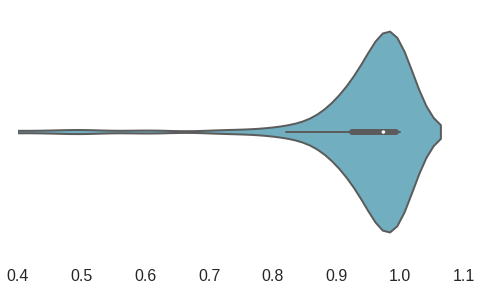

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 4.5))
sns.violinplot(seq_ident.values, vert=False, color = sns.color_palette()[5])
plt.xlim((0.4,1.1))

In [113]:
for_scoring['ssb_si_score'] = for_scoring.ssb_p_percent_seq_ident / seq_ident_stats_simple_cutoff_10

In [114]:
for_scoring.head()

u_seq_len  p_resolution  ssb_p_percent_seq_ident  \
u_uniprot_acc u_pdb                                                     
O32583        1F0Z          66           NaN                 1.000000   
              1ZUD          66          1.98                 1.000000   
P00350        2ZYA         468          1.60                 0.993590   
              2ZYD         468          1.50                 0.993590   
              3FWN         468          1.50                 0.995726   

                     ssb_p_aln_coverage  ssb_p_aln_coverage_sim  ssb_si_score  
u_uniprot_acc u_pdb                                                            
O32583        1F0Z                   66                      66      1.208995  
              1ZUD                   66                      66      1.208995  
P00350        2ZYA                  465                     465      1.201245  
              2ZYD                  465                     465      1.201245  
              3FWN                  466                     466      1.203828

## Scoring resolution

In [115]:
resolutions = for_scoring.p_resolution[pd.notnull(for_scoring.p_resolution)]
resolutions_stats = resolutions.describe(percentiles = [.1,.25,.5,.75,.9])
resolutions_simple_cutoff_75 = resolutions_stats['75%']
resolutions_simple_cutoff_90 = resolutions_stats['90%']
print resolutions_stats

count    3708.000000
mean        2.293873
std         0.984204
min         0.890000
10%         1.640000
25%         1.900000
50%         2.200000
75%         2.600000
90%         3.000000
max        28.000000
Name: p_resolution, dtype: float64


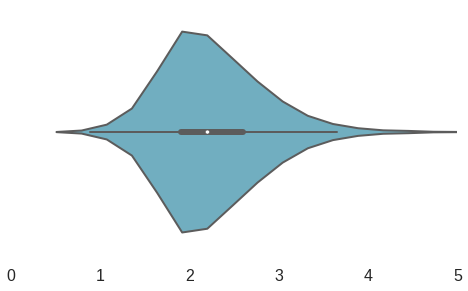

In [116]:
plt.figure(figsize=(8, 4.5))
plt.xlim((0,5))
sns.violinplot(resolutions.values, vert=False, color = sns.color_palette()[5])

In [118]:
# function to map to a 0 to 1 scale
# http://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio

def remap( x, oMin, oMax, nMin, nMax ):

    #range check
    if oMin == oMax:
        print "Warning: Zero input range"
        return None

    if nMin == nMax:
        print "Warning: Zero output range"
        return None

    #check reversed input range
    reverseInput = False
    oldMin = min( oMin, oMax )
    oldMax = max( oMin, oMax )
    if not oldMin == oMin:
        reverseInput = True

    #check reversed output range
    reverseOutput = False   
    newMin = min( nMin, nMax )
    newMax = max( nMin, nMax )
    if not newMin == nMin :
        reverseOutput = True

    portion = (x-oldMin)*(newMax-newMin)/(oldMax-oldMin)
    if reverseInput:
        portion = (oldMax-x)*(newMax-newMin)/(oldMax-oldMin)

    result = portion + newMin
    if reverseOutput:
        result = newMax - portion

    return result

In [120]:
resolutions_mod = pd.Series([remap(x, 0, 5, 1, 0) for x in resolutions])
resolutions_mod_stats = resolutions_mod.describe(percentiles = [.1,.25,.5,.75,.9])
resolutions_mod_simple_cutoff_10 = resolutions_mod_stats['10%']
resolutions_mod_simple_cutoff_25 = resolutions_mod_stats['25%']
print resolutions_mod_stats

count    3708.000000
mean        0.541225
std         0.196841
min        -4.600000
10%         0.400000
25%         0.480000
50%         0.560000
75%         0.620000
90%         0.672000
max         0.822000
dtype: float64


In [121]:
for_scoring['p_resolution_scaled'] = remap(for_scoring['p_resolution'], 0, 5, 1, 0)
for_scoring['ssb_rez_score'] = for_scoring['p_resolution_scaled']/resolutions_mod_simple_cutoff_10

## Merging scores & ranking

In [125]:
for_scoring['ssb_raw_score'] = for_scoring['ssb_rez_score'] + for_scoring['ssb_si_score']

In [132]:
import ranking as rk

def ranker(ranks, reverse_flag):
    pdb_rank = {}
    
    pdbs = [x[0] for x in ranks]
    prop = [x[1] for x in ranks]
    rank = list(rk.Ranking(prop, reverse=reverse_flag))

    for i,v in enumerate(rank):
        pdb_rank[pdbs[i]] = v[0]
        
    return pdb_rank

In [134]:
for_scoring['ssb_above_cutoffs'] = False
for_scoring['ssb_rank'] = np.nan

counter = 1
for uniprot_id in tqdm(for_scoring.index.get_level_values(0).unique()):
    
    pdb_ids = for_scoring.loc[uniprot_id].index.tolist()
    
    # if there are no PDBs associated with a UniProt ID, skip this UniProt ID
    if np.nan in pdb_ids:
        continue
    
    pdbs_above_cutoffs = []
    for pdb_id in pdb_ids:

        ssb_rez_score = for_scoring.loc[(uniprot_id,pdb_id)].ssb_rez_score
        ssb_si_score = for_scoring.loc[(uniprot_id,pdb_id)].ssb_si_score
        
        ssb_raw_score = for_scoring.loc[(uniprot_id,pdb_id)].ssb_raw_score
        
        if ssb_rez_score >= 1 and ssb_si_score >= 1:
            for_scoring.loc[(uniprot_id,pdb_id), 'ssb_above_cutoffs'] = True
            pdbs_above_cutoffs.append((pdb_id,ssb_raw_score))
            

    score_ordered = sorted(pdbs_above_cutoffs,key=lambda x: x[1], reverse=True)
    score_rank_ordered = ranker(score_ordered, reverse_flag=False)
    score_rank_ordered_list = [x[0] for x in sorted(score_rank_ordered.iteritems(), key=operator.itemgetter(1))]
    
    for pdb_id, raw_score in pdbs_above_cutoffs:
        for_scoring.loc[(uniprot_id,pdb_id), 'ssb_rank'] = score_rank_ordered_list.index(pdb_id) + 1

In [135]:
for_scoring.head()

u_seq_len  p_resolution  ssb_p_percent_seq_ident  \
u_uniprot_acc u_pdb                                                     
O32583        1F0Z          66           NaN                 1.000000   
              1ZUD          66          1.98                 1.000000   
P00350        2ZYA         468          1.60                 0.993590   
              2ZYD         468          1.50                 0.993590   
              3FWN         468          1.50                 0.995726   

                     ssb_p_aln_coverage  ssb_p_aln_coverage_sim  ssb_si_score  \
u_uniprot_acc u_pdb                                                             
O32583        1F0Z                   66                      66      1.208995   
              1ZUD                   66                      66      1.208995   
P00350        2ZYA                  465                     465      1.201245   
              2ZYD                  465                     465      1.201245   
              3FWN                  466                     466      1.203828   

                     p_resolution_scaled  ssb_rez_score  ssb_raw_score  \
u_uniprot_acc u_pdb                                                      
O32583        1F0Z                   NaN            NaN            NaN   
              1ZUD                 0.604           1.51       2.718995   
P00350        2ZYA                 0.680           1.70       2.901245   
              2ZYD                 0.700           1.75       2.951245   
              3FWN                 0.700           1.75       2.953828   

                    ssb_above_cutoffs  ssb_rank  
u_uniprot_acc u_pdb                              
O32583        1F0Z              False       NaN  
              1ZUD               True         1  
P00350        2ZYA               True         3  
              2ZYD               True         2  
              3FWN               True         1

In [151]:
best_pdbs = for_scoring[(for_scoring.ssb_rank == 1)]
best_pdbs.head()

,,u_seq_len,p_resolution,ssb_p_percent_seq_ident,ssb_p_aln_coverage,ssb_p_aln_coverage_sim,ssb_si_score,p_resolution_scaled,ssb_rez_score,ssb_raw_score,ssb_above_cutoffs,ssb_rank
u_uniprot_acc,u_pdb,,,,,,,,,,,
O32583,1ZUD,66,1.98,1.000000,66,66,1.208995,0.604,1.51,2.718995,True,1
P00350,3FWN,468,1.50,0.995726,466,466,1.203828,0.700,1.75,2.953828,True,1
P00363,1KF6,602,2.70,0.958472,577,577,1.158787,0.460,1.15,2.308787,True,1
P00370,4BHT,447,2.50,0.988814,442,442,1.195471,0.500,1.25,2.445471,True,1
P00448,1IXB,206,0.90,0.990291,204,205,1.197257,0.820,2.05,3.247257,True,1


In [140]:
FINAL_RESET = for_scoring.reset_index()

In [147]:
DF_GEMPRO = DF_02_RXN_GENE_UNIPROT_PDB_HOMOL.merge(FINAL_RESET, how='outer')

In [148]:
DF_GEMPRO.head()

,m_reaction,m_subsystem,m_formula,m_metabolites,m_gene_reaction_rule,m_gene,u_uniprot_acc,u_reviewed,u_gene_name,u_ec_number,u_description,u_seq,u_seq_len,u_pfam,u_kegg_id,u_refseq,u_go,u_pdb_count,u_pdb,p_experiment,p_resolution,p_chemicals,p_chains,p_chain_uniprot_map,p_ec_numbers,p_deposition_date,p_doi,p_pmid,p_space_group,i_entry_name,i_length,i_native,i_tm_helix,i_tm_score,ssb_p_percent_seq_ident,ssb_p_aln_coverage,ssb_p_aln_coverage_sim,ssb_si_score,p_resolution_scaled,ssb_rez_score,ssb_raw_score,ssb_above_cutoffs,ssb_rank
0,12PPDRtex,"Transport, Outer Membrane Porin",12ppd_DASH_R_e <=> 12ppd_DASH_R_p,"[12ppd_DASH_R_e, 12ppd_DASH_R_p]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,0.940171,330,330,1.136662,0.4,1,2.136662,True,1
1,12PPDStex,"Transport, Outer Membrane Porin",12ppd_DASH_S_e <=> 12ppd_DASH_S_p,"[12ppd_DASH_S_e, 12ppd_DASH_S_p]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,0.940171,330,330,1.136662,0.4,1,2.136662,True,1
2,23CAMPtex,"Transport, Outer Membrane Porin",23camp_e <=> 23camp_p,"[23camp_p, 23camp_e]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,0.940171,330,330,1.136662,0.4,1,2.136662,True,1
3,23CCMPtex,"Transport, Outer Membrane Porin",23ccmp_e <=> 23ccmp_p,"[23ccmp_e, 23ccmp_p]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,0.940171,330,330,1.136662,0.4,1,2.136662,True,1
4,23CGMPtex,"Transport, Outer Membrane Porin",23cgmp_e <=> 23cgmp_p,"[23cgmp_p, 23cgmp_e]",(b0241 or b0929 or b1377 or b2215),b0241,P02932,1,phoE,NaN,['Outer membrane pore protein E'],MKKSTLALVVMGIVASASVQAAEIYNKDGNKLDVYGKVKAMHYMSD...,351,['PF00267'],"['ecj:JW0231', 'eco:b0241']","['NP_414776.1', 'NC_000913.3', 'WP_000749863.1...",['GO:0009279; C:cell outer membrane; IEA:UniPr...,1,1PHO,X-RAY DIFFRACTION,3,NaN,['A'],{'A': ['P02932']},NaN,15-JAN-93,10.1038/358727A0,1380671,P 3 2 1,PHOE_ECOLI,351,1phoA,7,NaN,0.940171,330,330,1.136662,0.4,1,2.136662,True,1


In [149]:
DF_GEMPRO.to_pickle(os.path.join(DATA_FRAMES, 'DF_03_GEMPRO.pckl'))

# Saving the final GEM-PRO dataframe

In [190]:
DF_GEMPRO['ssb_best_file'] = np.nan

In [191]:
STRUCT_BEST_EXP_PERFECT = os.path.join(STRUCT_FILES, 'best_set/experimental_perfect/')
STRUCT_BEST_EXP_MUTATED = os.path.join(STRUCT_FILES, 'best_set/experimental_mutated/') 
STRUCT_BEST_HOMOLOGY = os.path.join(STRUCT_FILES, 'best_set/homology_models/')

In [192]:
for directory in [STRUCT_BEST_EXP_PERFECT, STRUCT_BEST_EXP_MUTATED, STRUCT_BEST_HOMOLOGY]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [193]:
os.chdir(STRUCT_BEST_EXP_PERFECT)
for uniprot_id,pdb_id in tqdm(best_pdbs.index.tolist()):
    pdb_id = pdb_id.lower()
    pdb_file = os.path.join(STRUCT_EXP_FILES, '%s.pdb' % pdb_id)
    
    if not os.path.exists(os.path.join(STRUCT_BEST_EXP_PERFECT, '%s.pdb' % pdb_id)):
        shutil.copy(pdb_file, STRUCT_BEST_EXP_PERFECT)
        
    indices = DF_GEMPRO[(DF_GEMPRO.u_uniprot_acc == uniprot_id)].index.tolist()
    for idx in indices:
        DF_GEMPRO.loc[idx, 'ssb_best_file'] = '%s.pdb' % pdb_id

In [194]:
errors = []
tmp2 = DF_GEMPRO[pd.notnull(DF_GEMPRO.i_entry_name)]
for uniprot_id in tqdm(DF_GEMPRO[pd.isnull(DF_GEMPRO.ssb_best_file)].u_uniprot_acc.unique().tolist()):
    
    try:
        itasser_name = tmp2[tmp2.u_uniprot_acc == uniprot_id].i_entry_name.unique()[0]
    except:
        errors.append(uniprot_id)
        continue
        
    itasser_file = '%s_model1.pdb' % itasser_name
    itasser_path = os.path.join(STRUCT_HOMOLOGY_FILES, itasser_file)
    
    if not os.path.exists(os.path.join(STRUCT_BEST_HOMOLOGY, itasser_file)):
        shutil.copy(itasser_path, STRUCT_BEST_HOMOLOGY)
        
    indices = DF_GEMPRO[(DF_GEMPRO.u_uniprot_acc == uniprot_id)].index.tolist()
    for idx in indices:
        DF_GEMPRO.loc[idx, 'ssb_best_file'] = itasser_file

In [195]:
# these do not have a homology model
errors

['P0AD88', 'P39400']

In [196]:
DF_GEMPRO.to_pickle(os.path.join(DATA_FRAMES, 'DF_03_GEMPRO.pckl'))